In [1]:
import sys
import pythoncyc as pc
import csv
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('/home/stef/Tb/reaction_mapping')
from utils import save_json, load_json, sanitize
from rdkit import Chem
from rdkit.Chem import AllChem
import itertools
from collections import Counter
m2s = Chem.MolToSmiles
s2m = Chem.MolFromSmiles

# Analyze mapping performance

In [2]:
# Load reactions and EC numbers

# Settings
filtered_mc_path = '../mapping/mc_rxns_final_221214.json' # mc_v21_as_is.json
using_jos_rxns = False # Whether or not to alter rxn ids to fit jos

# Read in ec numbers saved from mc
rxns_wo_ec = []
with open('mc_wo_ec.csv', 'r') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
            rxns_wo_ec.append(row[0])

rxns_w_ec = load_json('mc_ec.json')

print(len(list(rxns_w_ec.keys())) / (len(list(rxns_w_ec.keys())) + len(rxns_wo_ec)))

# Modify ec lists with reversed reaction ids
filtered_mc_rxns = load_json(filtered_mc_path)
filtered_rxns_w_ec = {}
filtered_rxns_wo_ec = []

if using_jos_rxns:
    for k,v in filtered_mc_rxns.items():
        if '|' + k.rstrip('_reverse') + '|' in rxns_wo_ec:
            filtered_rxns_wo_ec.append(k)
        elif '|' + k.rstrip('_reverse') + '|' in rxns_w_ec.keys():
            filtered_rxns_w_ec[k] = rxns_w_ec['|' + k.rstrip('_reverse') + '|']
else:
    for k,v in filtered_mc_rxns.items():
        if k.rstrip('_REV|') + '|' in rxns_wo_ec:
            filtered_rxns_wo_ec.append(k)
        elif k.rstrip('_REV|') + '|' in rxns_w_ec.keys():
            filtered_rxns_w_ec[k] = rxns_w_ec[k.rstrip('_REV|') + '|']

print(len(list(filtered_rxns_w_ec.keys())) / len(filtered_mc_rxns))

0.7913456141246109
0.8479018635205792


In [3]:
# Load in all rule names
rules_path = '../mapping/minimal1224_all_uniprot.tsv' # JN3604IMT_rules.tsv
all_rules = []
with open(rules_path, 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
        all_rules.append(row[0])

all_rules = all_rules[1:]

In [4]:
# Load mapping
suffix = '_mc_221214_min_rules_enforce_cof.csv' #_mc_v21_imt_rules_enforce_cof.csv
mapping_path = '../mapping/results/mapping' + suffix
missing_path = '../mapping/results/missing_smiles' + suffix
parse_path = '../mapping/results/smiles_parse_issues' + suffix
all_rxns = []
mapped_rxns = []
unmapped_rxns = []
missing_smiles = []
parse_issues  = []
rxn2rule = {}

with open(mapping_path, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        all_rxns.append(row[0])
        if len(row) == 1:
            unmapped_rxns.append(row[0])
            rxn2rule[row[0]] = []
        else:
            mapped_rxns.append(row[0])
            rxn2rule[row[0]] = row[1:]

# Load list of reactions missing smiles
with open(missing_path, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        missing_smiles.append(row[0])

# Load those with unparseable smiles
with open(parse_path, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        parse_issues.append(row[0])

# all_rxns = list(set(all_rxns) - set(missing_smiles))
# all_rxns = list(set(all_rxns) - set(parse_issues))
# unmapped_rxns = list(set(unmapped_rxns) - set(missing_smiles))
# unmapped_rxns = list(set(unmapped_rxns) - set(parse_issues))

print("Mapping fraction: {}".format(len(mapped_rxns) / len(all_rxns)))
print("Total # reactions analyzed: {}".format(len(all_rxns)))

Mapping fraction: 0.7737632390400858
Total # reactions analyzed: 14918


## Break down by EC

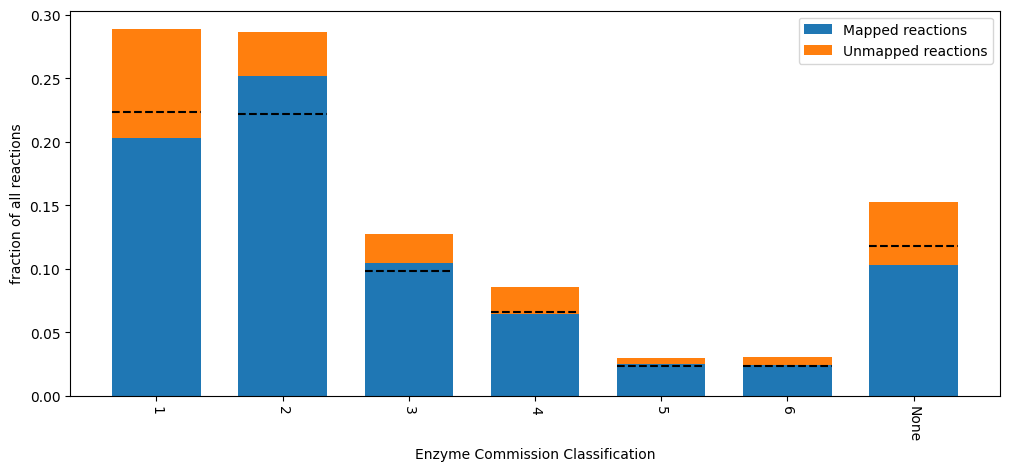

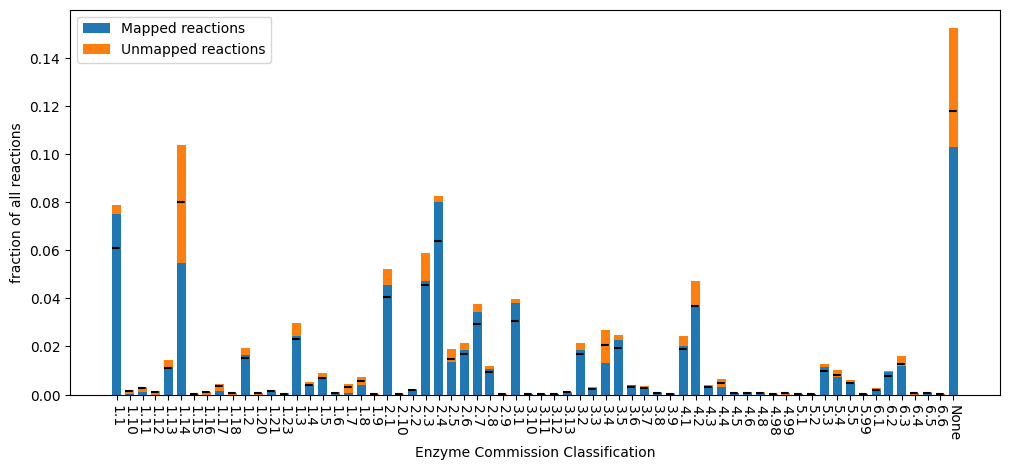

In [5]:
map_frac = len(mapped_rxns) / len(all_rxns)

# Counts by EC. Sublists correspond mapped, unmapped
# dicts from left to right are 1st digit, 2nd digit ec
# keys in dicts are ec #
ecc_arrs = [[{}, {}], [{}, {}]]
ec_to_rxn = [[{}, {}], [{}, {}]] # Same structure as ecc_arrs but tracks rxn ids, not counts
for i, arr in enumerate([mapped_rxns, unmapped_rxns]): # Iterate over mapped, unmapped lists
    for elt in arr: # Iterate over rxn ids in both lists

        if elt in filtered_rxns_w_ec.keys():
            this_ecc = filtered_rxns_w_ec[elt]
            this_ecc = this_ecc[0].lstrip('|EC-').rstrip('|').split('.')
            ecc1 = this_ecc[0]
            if ecc1 != '7': # Catch a few remaining tranport reactions

                # Catch entries with 1st but not
                # second digit ec... kludgy but ok for now
                if len(this_ecc) > 1:
                    ecc2 = ecc1 + '.' + this_ecc[1]
                else:
                    ecc2 = 'None'

                if ecc1 not in ecc_arrs[i][0]:
                    ecc_arrs[i][0][ecc1] = 1
                    ec_to_rxn[i][0][ecc1] = [elt]
                else:
                    ecc_arrs[i][0][ecc1] += 1
                    ec_to_rxn[i][0][ecc1].append(elt)

                if ecc2 not in ecc_arrs[i][1]:
                    ecc_arrs[i][1][ecc2] = 1
                    ec_to_rxn[i][1][ecc2] = [elt]
                else:
                    ecc_arrs[i][1][ecc2] += 1
                    ec_to_rxn[i][1][ecc2].append(elt)
        else:
            if 'None' not in ecc_arrs[i][0]:
                ecc_arrs[i][0]['None'] = 1
                ec_to_rxn[i][0]['None'] = [elt]
            else:
                ecc_arrs[i][0]['None'] += 1
                ec_to_rxn[i][0]['None'].append(elt)

            if 'None' not in ecc_arrs[i][1]:
                ecc_arrs[i][1]['None'] = 1
                ec_to_rxn[i][1]['None'] = [elt]
            else:
                ecc_arrs[i][1]['None'] += 1
                ec_to_rxn[i][1]['None'].append(elt)

ec_1st_union = list(set(ecc_arrs[0][0].keys()) | set(ecc_arrs[1][0].keys()))
ec_2nd_union = list(set(ecc_arrs[0][1].keys()) | set(ecc_arrs[1][1].keys()))
for elt in ecc_arrs:
    for k in ec_1st_union:
        if k not in elt[0].keys():
            elt[0][k] = 0

    for k in ec_2nd_union:
        if k not in elt[1].keys():
            elt[1][k] = 0


# Make two plots
labels = ['Mapped reactions', 'Unmapped reactions']
width = 0.7
ymax = [0.55, 0.35]
for i in range(2): # Iterate over 2 levels of ecc
    fig, ax = plt.subplots(figsize=(12,5))
    tot = sum(list(ecc_arrs[0][i].values())) + sum(list(ecc_arrs[1][i].values()))
    

    for j in range(2): # Iterate over mapped, unmapped
        xs = np.arange(len(ecc_arrs[j][i]))
        names = sorted(list(ecc_arrs[j][i].keys()))
        values = np.array([ecc_arrs[j][i][name] for name in names])
        values = values / tot

        if j == 0:
            ax.bar(xs, values, width=width, tick_label=names, label=labels[j])
            last_names = names
            last_values = values
        else:
            ax.bar(xs, values, width=width, tick_label=names, label=labels[j], bottom=last_values)
            ax.set_xticklabels(names, rotation=-90)
        
    # Make chance lines
    for k, x in enumerate(xs):
        top = last_values[k] + values[k]
        ax.hlines(top * map_frac, x - width / 2, x + width / 2, color='k', ls='--')
        # ax.hlines(top * jos_overall_map_frac, x - width / 2, x + width / 2, color='g', ls='--')
    
    # ax.set_ylim(0, ymax[i])
    ax.set_xlabel(f"Enzyme Commission Classification")
    ax.set_ylabel('fraction of all reactions')
    ax.legend()
    plt.show()

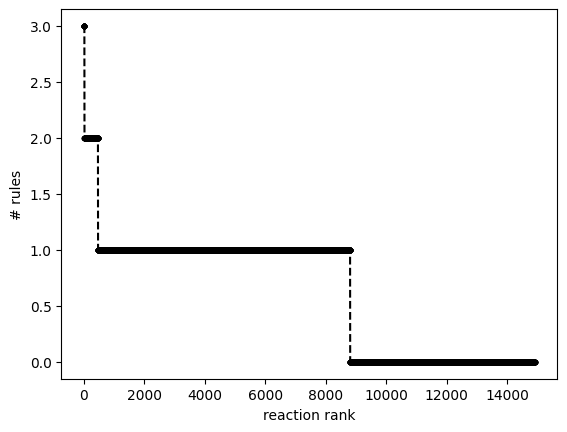

In [7]:
# Plot rule counts by reaction (on most specific level available)
n_rules_per_rxn = sorted([len(elt) for elt in rxn2rule.values()], reverse=True)
fig, ax = plt.subplots()
ax.plot(np.arange(1, len(n_rules_per_rxn) + 1), n_rules_per_rxn, 'k.--')
ax.set_xlabel('reaction rank')
ax.set_ylabel('# rules')
plt.show()

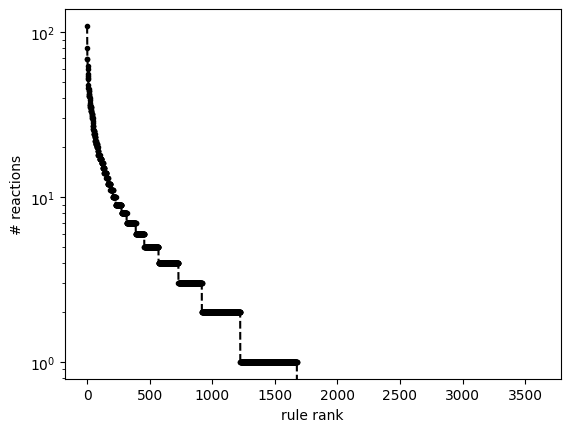

Mean rxns mapped: 2.579356270810211


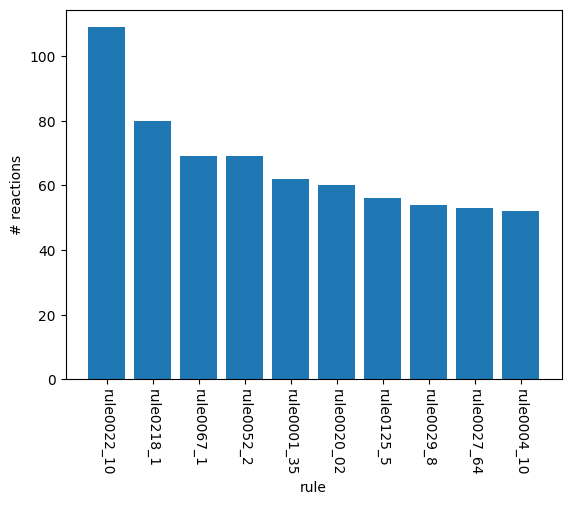

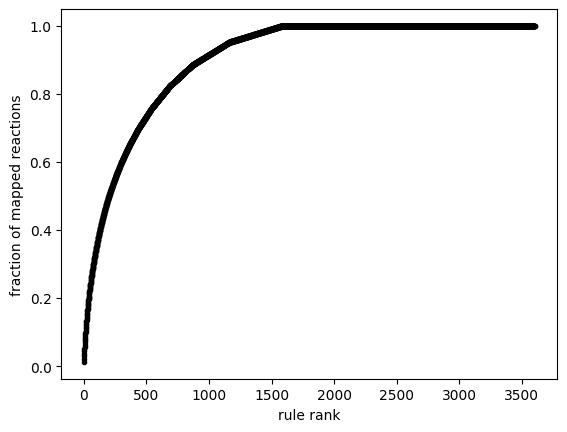

635


In [8]:
# Plot reaction counts by rule
rule2rxn = {}
for k,v in rxn2rule.items():
    for elt in v:
        if elt not in rule2rxn:
            rule2rxn[elt] = [k]
        else:
            rule2rxn[elt].append(k)

rule_ids = list(rule2rxn.keys())
n_rxns_by_rule = [len(elt) for elt in rule2rxn.values()]
rules_rxn_ct_sorted = [[elt[1], elt[0]] for elt in sorted(zip(n_rxns_by_rule, rule_ids), reverse=True)]

# Find rules not in mapping
for elt in all_rules:
    if elt not in rule_ids:
        rules_rxn_ct_sorted.append([elt, 0]) # Tack on with n_rxns=0

rules, rxn_cts = list(zip(*rules_rxn_ct_sorted)) # Sort cts and rule names together

# Order rules by those that contribute the maximum
# number of "new" reactions to the mapping pool as possible
mapping_pool = set()
max_delta_sorted = [] # Reactions sorted by contribution to the mapping pool
deltas = []
search_space = all_rules.copy()

# Go until you've gotten all the rules
while len(max_delta_sorted) < len(all_rules):
    best_contribution = set()
    best_delta = 0
    # Iterate over search space to find max contribution
    for elt in search_space:
        if elt in rule2rxn.keys():
            this_rxns = set(rule2rxn[elt])
        else:
            this_rxns = set()

        this_contribution = this_rxns - mapping_pool # In this rxns but not pool
        this_delta = len(this_contribution)
        if this_delta >= best_delta:
            best_contribution = this_contribution
            best_delta = this_delta
            best_id = elt

    # Update pool
    mapping_pool = mapping_pool | best_contribution
    deltas.append(best_delta)
    max_delta_sorted.append(best_id)
    search_space.remove(best_id) # Reduce search space by the rule you got

rxn_ct_cdf = np.cumsum(deltas) / len(mapped_rxns)
eighty_percent = np.where(np.array(rxn_ct_cdf) > 0.8)[0][0]

# Plot all cts w/o rule names
fig, ax = plt.subplots()
ax.plot(rxn_cts, 'k.--')
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlabel('rule rank')
ax.set_ylabel('# reactions')
plt.show()
print("Mean rxns mapped: {}".format(sum(rxn_cts) / len(rxn_cts)))

# Plot top n rules
n = 10
fig, ax = plt.subplots()
ax.bar(np.arange(n), rxn_cts[:n], tick_label=rules[:n])
ax.set_xticklabels(rules[:n], rotation=-90)
ax.set_xlabel('rule')
ax.set_ylabel('# reactions')
plt.show()

# Plot cumulative distr
fig, ax = plt.subplots()
ax.plot(rxn_ct_cdf, 'k.--')
ax.set_xlabel('rule rank')
ax.set_ylabel('fraction of mapped reactions')
plt.show()
print(eighty_percent)

In [182]:
# Intermediate only

unused = rules[rxn_cts.index(0):]
unused_min = {}
for elt in unused:
    k = elt.split('_')[0]
    if k not in unused_min:
        unused_min[k] = 1
    else:
        unused_min[k] += 1

zipped_rules = [*unused_min.items()]
rezipped_rules = list(zip(list(zip(*zipped_rules))[1], list(zip(*zipped_rules))[0])) 

rule_name, imt_unused_cts = list(zip(*[(elt[1], elt[0]) for elt in sorted(rezipped_rules, reverse=True)]))

In [130]:
# Intermediate rules only!
# Re-do rule cts by reaction with general
# rule ids

# Make dict with rule cts per reaction
# described only by the general rule id
gen_imt_rxn_by_rule = np.zeros(shape=(len(all_rxns), len(all_rules)))

for i,id in enumerate(all_rxns):
    this_rxn_rules = rxn2rule[id]
    this_ct = [0 for j in range(len(all_rules))]
    for elt in this_rxn_rules:
        idx = int(elt.lstrip('rule').split('_')[0])
        this_ct[idx] += 1
    gen_imt_rxn_by_rule[i,:] = this_ct
    
rxn_idxs, rule_idxs = np.where(gen_imt_rxn_by_rule > 1)
print(len(rxn_idxs))

522


# Compare with josephs mapping

In [88]:
# Load josephs original reaction data w/ mapping assignments
jos_rxns = load_json('../jos_rxn_data/metacyc.json')

In [89]:
# Jos mapfrac
jos_mapped = {}
jos_unmapped = []
for elt in all_rxns:
    if jos_rxns[elt][-1] != 'Unmapped':
        jos_mapped[elt] = jos_rxns[elt][-1]
    else:
        jos_unmapped.append(elt)

jos_overall_map_frac = len(jos_mapped) / len(all_rxns)
print(jos_overall_map_frac)

# Get reactions that jos mapped but I missed
missed = []
for elt in all_rxns:
    if (len(rxn2rule[elt]) == 0) & (jos_rxns[elt][-1] != 'Unmapped'):
        missed.append(elt)

0.8325446282153399


In [100]:
tp = list(set(mapped_rxns) & set(jos_mapped)) # True positives
fp = list(set(mapped_rxns) & set(jos_unmapped)) # False positives
fn = list(set(unmapped_rxns) & set(jos_mapped)) # Missed / false negatives
tn = list(set(unmapped_rxns) & set(jos_unmapped)) # True negatives

print("True positives: {}, False positives: {}, False negatives: {}, True negatives: {}".format(len(tp), len(fp), len(fn), len(tn)))
print("Sensitivity: {}, Specificity: {}".format(len(tp) / (len(tp) + len(fn)), len(tn) / (len(tn) + len(fp))))

True positives: 17632, False positives: 51, False negatives: 137, True negatives: 3523
Sensitivity: 0.992289943159435, Specificity: 0.9857302742025742


In [115]:
inspect_id = '2.1.1.19-RXN'
print(jos_rxns[inspect_id][-1], rxn2rule[inspect_id])
print(filtered_mc_rxns[inspect_id])

rule0205 ['rule0033']
[{'5-METHYL-THF-GLU-N:0': '*C(=O)CC[C@H](NC(=O)c1ccc(NC[C@H]2CNc3nc(N)[nH]c(=O)c3N2C)cc1)C(=O)O', 'CPD-7670:0': 'CSC'}, {'THF-GLU-N:0': '*C(=O)CC[C@H](NC(=O)c1ccc(NC[C@H]2CNc3nc(N)[nH]c(=O)c3N2)cc1)C(=O)O', 'TRIMETHYLSULFONIUM:0': 'C[S+](C)C'}]


In [84]:
test = {inspect_id:filtered_mc_rxns[inspect_id]}
save_json(test, '/home/stef/Tb/reaction_mapping/mapping/test_rxn.json')

In [85]:
test_rule_id = 'rule0677'

# Read in rules
rules = []
with open(rules_path, 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
        rules.append(row[:4])

rules = rules[1:] # Remove header


test_rule_id = int(test_rule_id.lstrip('rule')) -1
header = ['Name', 'Reactants', 'SMARTS', 'Products', 'Comments']
test_rule = rules[test_rule_id]
print(test_rule)

with open('../mapping/test_rule.tsv', 'w') as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerow(header)
    writer.writerow(test_rule)

['rule0677', 'Any;WATER;Ubiquinones_CoF', '[#7:1].[#8:2].[#8:3]=[#6:4]1-[#6:5]=[#6:6]-[#6:7](=[#8:8])-[#6:9]=[#6:10]-1>>[#7+:1]-[#8:2].[#8:3]-[#6:4]1:[#6:10]:[#6:9]:[#6:7](-[#8:8]):[#6:6]:[#6:5]:1', 'Any;Ubiquinols_CoF']


In [107]:
# Look at mismatches in mapped reactions

mismatch = []
for elt in tp:
    jo = jos_rxns[elt][-1]
    me = rxn2rule[elt][0]
    if jo != me:
        mismatch.append(elt)
len(mismatch)

40

In [25]:
# Get true positives
tp_rxns = {}
for elt in tp:
    tp_rxns[elt] = filtered_mc_rxns[elt]

save_json(tp_rxns, '../mapping/true_positive_mc_min.json')

In [28]:
tp_sample = load_json('../mapping/10_true_pos_mc_v21_rxns_rnd_seed_1234.json')
for k in tp_sample.keys():
    print(k, jos_rxns[k][-1], rxn2rule[k])

RXN-15323 rule0001 ['rule0001', 'rule0006', 'rule0007', 'rule0008', 'rule0009', 'rule0096', 'rule0097', 'rule0104', 'rule0105']
RXN-5101 rule0368 ['rule0368']
RXN-13785 rule0006 ['rule0001', 'rule0006', 'rule0007', 'rule0008', 'rule0009', 'rule0096', 'rule0097', 'rule0104', 'rule0105', 'rule1088']
3-5-XYLENOL-METHYLHYDROXYLASE-RXN_reverse rule0004 ['rule0004']
2.4.1.27-RXN_reverse rule0008 ['rule0001', 'rule0006', 'rule0007', 'rule0008', 'rule0009', 'rule0096', 'rule0097', 'rule0104', 'rule0105', 'rule0431', 'rule0517']
RXN-662 rule0003 ['rule0003']
RXN-14424_reverse rule0008 ['rule0001', 'rule0006', 'rule0007', 'rule0008', 'rule0009', 'rule0096', 'rule0097', 'rule0104', 'rule0105', 'rule0431', 'rule0517']
4-HYDROXYMANDELATE-OXY-RXN rule0355 ['rule0355']
RXN-11073_reverse rule0013 ['rule0013', 'rule0056', 'rule0099', 'rule0122', 'rule0162', 'rule0195', 'rule0430']
RXN-17712 rule0133 ['rule0133']


In [137]:
# Load mapping
suffix = '_mc_v21_imt_rules_enforce_cof.csv' #_mc_221214_imt_rules_enforce_cof.csv _mc_v21_fn_min_rules.csv
mapping_path = '../mapping/mapping' + suffix
missing_path = '../mapping/missing_smiles' + suffix
parse_path = '../mapping/smiles_parse_issues' + suffix
imt_unmapped_rxns = []
missing_smiles = []
parse_issues  = []

with open(mapping_path, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        if len(row) == 1:
            imt_unmapped_rxns.append(row[0])

# Load list of reactions missing smiles
with open(missing_path, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        missing_smiles.append(row[0])

# Load those with unparseable smiles
with open(parse_path, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        parse_issues.append(row[0])

imt_unmapped_rxns = list(set(imt_unmapped_rxns) - set(missing_smiles))
imt_unmapped_rxns = list(set(imt_unmapped_rxns) - set(parse_issues))

In [165]:
# How much do each general rule "leak"?
rule2leak = {}
for k,v in rxn2rule.items():
    if (len(v) != 0) & (k in imt_unmapped_rxns):
        if v[0] not in rule2leak:
            rule2leak[v[0]] = 1
        else:
            rule2leak[v[0]] += 1

zipped_rules = [*rule2leak.items()]
rezipped_rules = list(zip(list(zip(*zipped_rules))[1], list(zip(*zipped_rules))[0])) 

rule_name, leak_cts = list(zip(*[(elt[1], elt[0]) for elt in sorted(rezipped_rules, reverse=True)]))

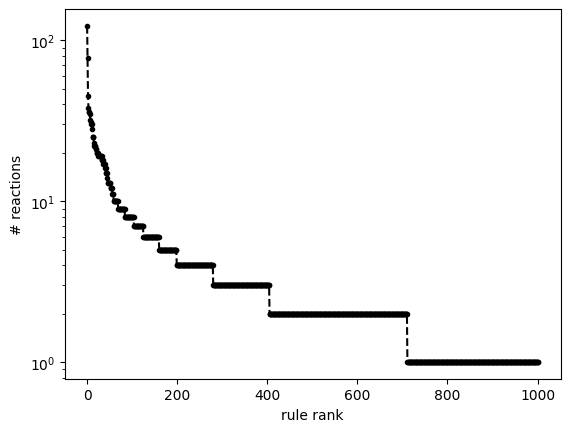

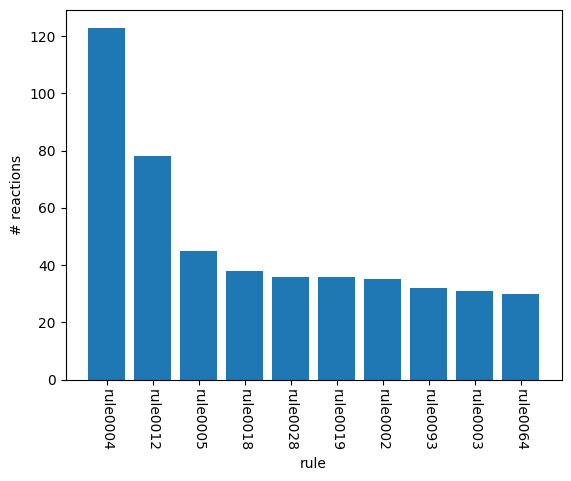

In [174]:
# Plot all cts w/o rule names
fig, ax = plt.subplots()
ax.plot(leak_cts, 'k.--')
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlabel('rule rank')
ax.set_ylabel('# reactions')
plt.show()

# Plot top n rules
n = 10
fig, ax = plt.subplots()
ax.bar(np.arange(n), leak_cts[:n], tick_label=rule_name[:n])
ax.set_xticklabels(rule_name[:n], rotation=-90)
ax.set_xlabel('rule')
ax.set_ylabel('# reactions')
plt.show()

In [172]:
sum(leak_cts)

3901

# Characterize rules by EC

In [9]:
rule2ecs = {}
for i, elt in enumerate(mapped_rxns): # Iterate over mapped, unmapped lists

    if elt in filtered_rxns_w_ec.keys():
        this_ec = filtered_rxns_w_ec[elt]
        this_ec = this_ec[0].lstrip('|EC-').rstrip('|').split('.')

        this_rules = rxn2rule[elt] # Rules that mapped this rxn

        for elt2 in this_rules:
            if elt2 not in rule2ecs:
                rule2ecs[elt2] = [] # List of lists
                rule2ecs[elt2].append(['.'.join(this_ec[0])]) # First digit
                rule2ecs[elt2].append(['.'.join(this_ec[:2])]) # Second digit
                rule2ecs[elt2].append(['.'.join(this_ec[:3])]) # Third digit
                rule2ecs[elt2].append(['.'.join(this_ec)]) # Full EC
            else:
                rule2ecs[elt2][0].append('.'.join(this_ec[0])) # First digit
                rule2ecs[elt2][1].append('.'.join(this_ec[:2])) # Second digit
                rule2ecs[elt2][2].append('.'.join(this_ec[:3])) # third digit
                rule2ecs[elt2][3].append('.'.join(this_ec)) # Full EC

temp = {}
for k, v in rule2ecs.items():
    temp[k] = [dict(Counter(elt)) for elt in v]
rule2ecs = temp
len(rule2ecs.keys())

1607

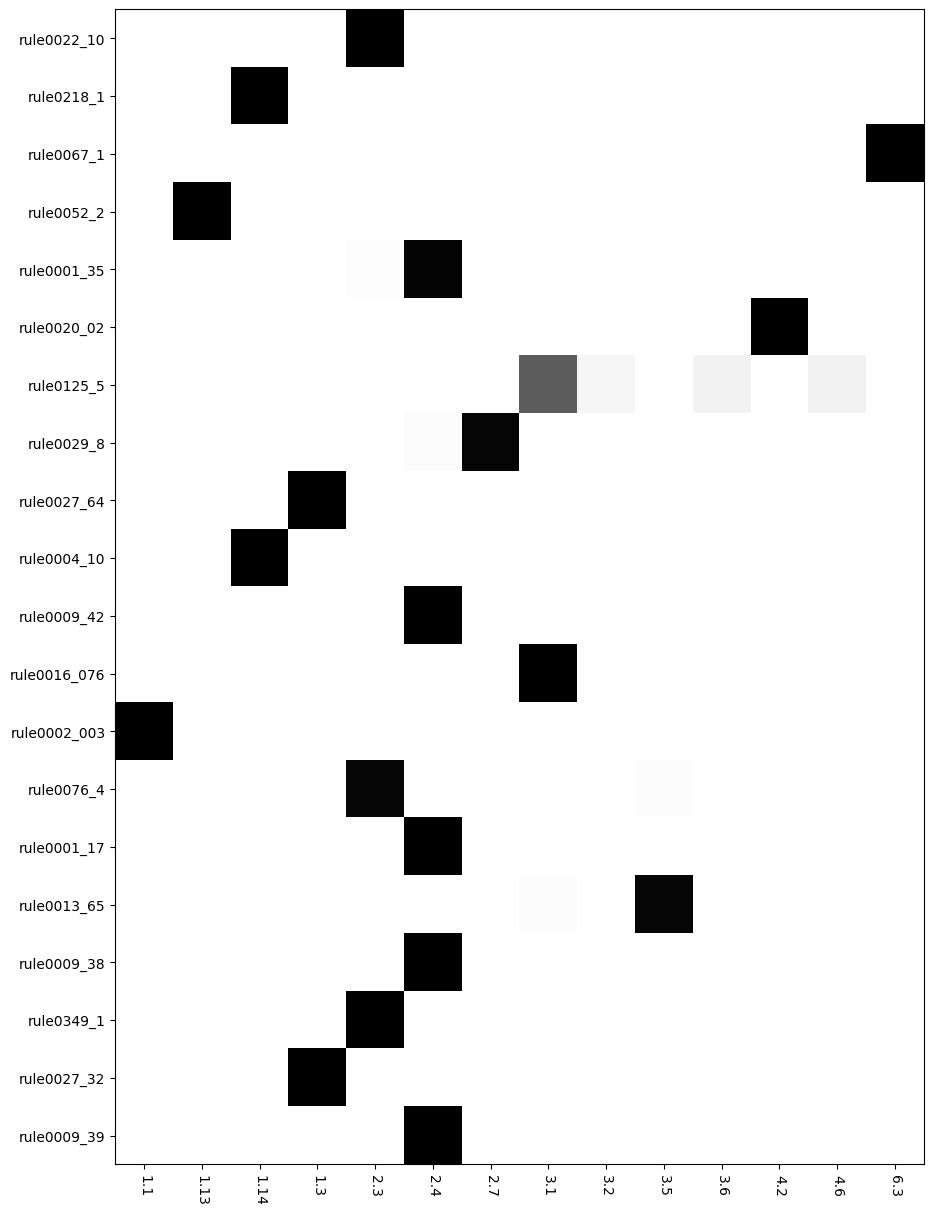

In [10]:
n = 20
top_n_rules = rules[:n]

# Get all ECs at some digit level
level = 1 # Zero indexed
digits = []
for elt in top_n_rules:
    digits += list(rule2ecs[elt][level].keys())

digits = sorted(list(set(digits)))

digit_cts = []
for i, elt in enumerate(top_n_rules):
    digit_cts.append([])
    for elt2 in digits:
        if elt2 in rule2ecs[elt][level]:
            digit_cts[i].append(rule2ecs[elt][level][elt2])
        else:
            digit_cts[i].append(0)

digit_cts = np.array(digit_cts)
digit_cts = digit_cts / digit_cts.sum(axis=1).reshape(-1,1)

fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(digit_cts, cmap='Greys')
ax.set_xticks(np.arange(len(digits)))
ax.set_xticklabels(digits, rotation=-90)
ax.set_yticks(np.arange(len(top_n_rules)))
ax.set_yticklabels(top_n_rules)

plt.show()

In [75]:
digit_cts

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.15308642, 0.83703704, 0.00246914, 0.00246914,
        0.00493827, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.99346405, 0.00163399, 0.        , 0.00163399, 0.00326797,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.99508197, 0.00163934, 0.        , 0.00163934, 0.00163934,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.       

In [29]:
rule2ecs['rule0027']

[{'1': 126},
 {'1.3': 115, '1.1': 10, '1.17': 1},
 {'1.3.1.3': 4,
  '1.3.1.31': 1,
  '1.3.1.100': 1,
  '1.3.1.115': 2,
  '1.3.1.54': 1,
  '1.3.1.72': 4,
  '1.3.1.22': 7,
  '1.3.1.69': 1,
  '1.1.1.M10': 6,
  '1.3.1': 24,
  '1.3.1.M12': 1,
  '1.1.1': 3,
  '1.3.1.44': 4,
  '1.3.1.16': 1,
  '1.3.1.93': 14,
  '1.3.1.21': 4,
  '1.3.1.73': 1,
  '1.3.1.105': 4,
  '1.3.1.aa': 2,
  '1.3.1.70': 3,
  '1.3.1.5': 1,
  '1.3.1.81': 2,
  '1.3.1.82': 1,
  '1.3.1.103': 1,
  '1.3.1.117': 1,
  '1.3.1.114': 4,
  '1.17.1': 1,
  '1.3.1.7': 1,
  '1.3.1.94': 1,
  '1.3.1.6': 1,
  '1.3.1.38': 2,
  '1.3.1.48': 1,
  '1.3.1.M16': 1,
  '1.3.1.11': 1,
  '1.3.1.32': 1,
  '1.3.1.95': 1,
  '1.3.1.74': 1,
  '1.3.1.116': 1,
  '1.3.1.84': 1,
  '1.3.1.17': 1,
  '1.3.1.34': 1,
  '1.3.1.24': 2,
  '1.3.1.71': 1,
  '1.3.1.86': 1,
  '1.3.1.42': 1,
  '1.3.1.102': 1,
  '1.3.1.27': 1,
  '1.3.1.98': 1,
  '1.3.1.62': 1,
  '1.1.1.M23': 1,
  '1.3.1.92': 1,
  '1.3.1.8': 1}]

In [ ]:
# Pull metacyc ec descriptions

# Store table with rule | top 1st digit | top second digit | second second digit...

# Store table structured similarly with rule | top class name | top subclass | second subclass...

# Scrap

In [45]:
test = {elt:filtered_mc_rxns[elt] for elt in fn}
save_json(test, '/home/stef/Tb/reaction_mapping/mapping/false_negatives.json')

In [16]:
max_products = 1000
rxnid = 'RXN-14519' # 'RXN-11842'
reactants = sanitize(list(filtered_mc_rxns[rxnid][0].values()))
products = sanitize(list(filtered_mc_rxns[rxnid][1].values()))
rule = '[#16:1].[#6:2]-[#7:3]>>[#6:2]-[#16+:1].[#7:3]' # '([#6:1].[#6:2]-[#7:3])>>([#7:3].[#6:1]-[#6:2])' 
operator = Chem.rdChemReactions.ReactionFromSmarts(rule) # Make reaction object from smarts string
reactants_mol = tuple([Chem.MolFromSmiles(elt) for elt in reactants]) # Convert reactant smiles to mol obj
outputs = operator.RunReactants(reactants_mol, maxProducts=max_products)
outputs_smis = [[m2s(elt2) for elt2 in elt] for elt in outputs]


In [17]:
for elt in outputs_smis:
    mapped = len(set(products) - set(elt)) == 0
    print(mapped)

False
False
False


In [18]:
outputs_smis

[['*OP(=O)(O)OCC1OC([S+](CCC(N)C(=O)O)CC2OC(n3cnc4c(N)ncnc43)C(O)C2O)C(O)C1OP(=O)(O)O*',
  'Cc1nc2n(C)c3ncnc3c(=O)n2c1CCC(N)C(=O)O'],
 ['*OP(=O)(O)OCC1OC(n2cnc3c(=O)n4c(CCC(C(=O)O)[S+](CCC(N)C(=O)O)CC5OC(n6cnc7c(N)ncnc76)C(O)C5O)c(C)nc4n(C)c32)C(O)C1OP(=O)(O)O*',
  'N'],
 ['C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)C1O',
  '*OP(=O)(O)OCC1OC(n2cnc3c(=O)n4c(CCC(N)C(=O)O)c(C)nc4nc32)C(O)C1OP(=O)(O)O*']]

In [19]:
for output in outputs_smis:
    san_smi_outputs = postsanitize_smiles(outputs_smis[2])
    for elt in san_smi_outputs:
        mapped = len(set(products) - set(elt)) == 0
        if mapped:
            print(elt)

NameError: name 'postsanitize_smiles' is not defined

In [ ]:
san_smi_outputs

[('C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)C1O',
  '*OP(=O)(O)OCC1OC(n2cnc3c(=O)n4c(CCC(N)C(=O)O)c(C)[nH]c4nc32)C(O)C1OP(=O)(O)O*'),
 ('C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)C1O',
  '*OP(=O)(O)OCC1OC(n2cnc3c(=O)n4c(CCC(N)C(=O)O)c(C)nc4[nH]c32)C(O)C1OP(=O)(O)O*')]

In [ ]:
for elt in san_smi_outputs[0]:
    if elt == products[0]:
        print(elt)

*OP(=O)(O)OCC1OC(c2c[nH]c(=O)[nH]c2=O)C(O)C1OP(=O)(O)O*


In [ ]:
san_smi_outputs[0][-1]

'O'

In [ ]:
def postsanitize_smiles(smiles_list):
    """Postsanitize smiles after running SMARTS.
    :returns tautomer list of list of smiles"""

    sanitized_list = []
    tautomer_smarts = '[#7H1X3&a:1]:[#6&a:2]:[#7H0X2&a:3]>>[#7H0X2:1]:[#6:2]:[#7H1X3:3]'

    for s in smiles_list:

        temp_mol = Chem.MolFromSmiles(s, sanitize=False)
        aromatic_bonds = [i.GetIdx() for i in temp_mol.GetBonds() if i.GetBondType() == Chem.rdchem.BondType.AROMATIC]

        for i in temp_mol.GetBonds():
            if i.GetBondType() == Chem.rdchem.BondType.UNSPECIFIED:
                i.SetBondType(Chem.rdchem.BondType.SINGLE)

        try:
            Chem.SanitizeMol(temp_mol)
            Chem.rdmolops.RemoveStereochemistry(temp_mol)
            temp_smiles = Chem.MolToSmiles(temp_mol)

        except Exception as msg:
            if 'Can\'t kekulize mol' in str(msg):
                pyrrole_indices = [i[0] for i in temp_mol.GetSubstructMatches(Chem.MolFromSmarts('n'))]

                # indices to sanitize
                for s_i in pyrrole_indices:
                    temp_mol = Chem.MolFromSmiles(s, sanitize=False)
                    if temp_mol.GetAtomWithIdx(s_i).GetNumExplicitHs() == 0:
                        temp_mol.GetAtomWithIdx(s_i).SetNumExplicitHs(1)
                    elif temp_mol.GetAtomWithIdx(s_i).GetNumExplicitHs() == 1:
                        temp_mol.GetAtomWithIdx(s_i).SetNumExplicitHs(0)
                    try:
                        Chem.SanitizeMol(temp_mol)

                        processed_pyrrole_indices = [i[0] for i in
                                                     temp_mol.GetSubstructMatches(Chem.MolFromSmarts('n'))]
                        processed_aromatic_bonds = [i.GetIdx() for i in
                                                    temp_mol.GetBonds() if i.GetBondType() == Chem.rdchem.BondType.AROMATIC]
                        if processed_pyrrole_indices != pyrrole_indices or aromatic_bonds != processed_aromatic_bonds:
                            continue

                        Chem.rdmolops.RemoveStereochemistry(temp_mol)
                        temp_smiles = Chem.MolToSmiles(temp_mol)
                        break
                    except:
                        continue
                if 'temp_smiles' not in vars():
                    Chem.rdmolops.RemoveStereochemistry(temp_mol)
                    temp_smiles = Chem.MolToSmiles(temp_mol)
                    sanitized_list.append([temp_smiles])
                    continue
            else:
                Chem.rdmolops.RemoveStereochemistry(temp_mol)
                temp_smiles = Chem.MolToSmiles(temp_mol)
                sanitized_list.append([temp_smiles])
                continue
        rxn = AllChem.ReactionFromSmarts(tautomer_smarts)

        try:
            tautomer_mols = rxn.RunReactants((Chem.MolFromSmiles(temp_smiles), ))
        except:
            try:
                tautomer_mols = rxn.RunReactants((Chem.MolFromSmiles(temp_smiles, sanitize=False),))
            except:
                continue

        tautomer_smiles = [Chem.MolToSmiles(m[0]) for m in tautomer_mols]
        sanitized_list.append(sorted(set(tautomer_smiles + [temp_smiles])))

    return list(itertools.product(*sanitized_list))